In [1]:
!pip install pyarrow==14.0.1 requests==2.31.0 cudf-cu12==24.4.1 google-colab==1.0.0 ibis-framework==8.0.0 datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2


In [2]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
import re
import string
from sklearn.model_selection import train_test_split
import os
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import numpy as np

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel

In [4]:
data = load_dataset("Rami/multi-label-class-github-issues-text-classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1556 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/778 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/778 [00:00<?, ? examples/s]

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['title', 'labels', 'bodyText'],
        num_rows: 1556
    })
    test: Dataset({
        features: ['title', 'labels', 'bodyText'],
        num_rows: 778
    })
    valid: Dataset({
        features: ['title', 'labels', 'bodyText'],
        num_rows: 778
    })
})

In [6]:
def find_unique_tags(list_of_lists):
    # Flatten the list of lists
    flat_list = [item for sublist in list_of_lists for item in sublist]

    # Find unique elements
    unique_elements = list(set(flat_list))

    return unique_elements

# Example usage
list_of_lists = data['train']['labels']

unique_elements = find_unique_tags(list_of_lists)

In [7]:
len(unique_elements)

36

In [8]:
data['train']['bodyText'][0]

'🐛 Bug\nIf I try to use torch-xla nightly with PyTorch Lightning, I see this crash:\n(torch-xla-nightly) zcain@zcain-pl-verify:~/pytorch-lightning/pl_examples/domain_templates$ python computer_vision_fine_tuning.py \nTraceback (most recent call last):\n  File "computer_vision_fine_tuning.py", line 55, in <module>\n    import pytorch_lightning as pl\n  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/pytorch_lightning/__init__.py", line 65, in <module>\n    from pytorch_lightning.trainer import Trainer\n  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/pytorch_lightning/trainer/__init__.py", line 18, in <module>\n    from pytorch_lightning.trainer.trainer import Trainer\n  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py", line 30, in <module>\n    from pytorch_lightning.loggers import LightningLoggerBase\n  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/pytorch_lightning/

In [9]:
def clean_strings(input_list):
    cleaned_list = []
    for s in input_list:
        # Check if the first character is not an alphabet
        if s and not s[0].isalpha():
            # Remove the first character and the following space
            s = re.sub(r'^\S\s', '', s, count=1)
        cleaned_list.append(s)
    return cleaned_list

my_list = data['train']['bodyText']

In [10]:
title = data['train']['title']
body = clean_strings(my_list)

# Using a list comprehension to concatenate corresponding elements
text_data = [str1 + " " + str2 for str1, str2 in zip(title, body)]

print(len(text_data))


1556


In [11]:
def concatenate_strings_in_list(input_list):
    concatenated_list = []
    for string in input_list:
        # Replace '\n' with ' ' and strip any extra whitespace
        concatenated_string = string.replace('\n', ' ').strip()
        concatenated_list.append(concatenated_string)
    return concatenated_list

# Example usage

text_data = concatenate_strings_in_list(text_data)
text_data[1]


'Fix docs typo in starter files Documentation For typos and doc fixes, please go ahead and:  Create an issue. Fix the typo. Submit a PR.  Thanks!'

In [12]:
data_array = text_data # Replace with the actual method to access your data
labels = data['train']['labels']  # Replace with the actual method to access your labels

# Combine data and labels into a DataFrame
df = pd.DataFrame(data_array,columns=['text'])
df['label'] = labels

In [13]:
df.head(10)

,text,label
0,TPUs: crash using torch-xla nightly Bug If I t...,"[bug, help wanted, won't fix, accelerator: tpu]"
1,Fix docs typo in starter files Documentation F...,[docs]
2,Fix typo in starter files Documentation For ty...,[docs]
3,on_*_batch_transfer hooks should include a dat...,"[feature, help wanted]"
4,Allow arbitrary val check intervals when using...,"[feature, help wanted]"
5,is auto_find_lr support ddp mode? Bug Please ...,"[bug, help wanted]"
6,Mixed precision not working with v 1.2 Bug Aft...,"[bug, help wanted, priority: 0]"
7,Encapsulate logic in DistributedType Feature A...,"[help wanted, good first issue, refactor]"
8,Parameterized freeze/unfreeze functions for fi...,"[feature, help wanted, won't fix]"
9,DDP does not work well with `torch.no_grad()` ...,"[bug, help wanted, distributed, priority: 1]"


In [14]:
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the labels column
one_hot_encoded = mlb.fit_transform(df['label'])

# Create a DataFrame with the one-hot encoded labels
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = pd.concat([df, one_hot_df], axis=1)
df.drop('label', axis=1, inplace=True)

In [15]:
df['text'][0]

'TPUs: crash using torch-xla nightly Bug If I try to use torch-xla nightly with PyTorch Lightning, I see this crash: (torch-xla-nightly) zcain@zcain-pl-verify:~/pytorch-lightning/pl_examples/domain_templates$ python computer_vision_fine_tuning.py  Traceback (most recent call last):   File "computer_vision_fine_tuning.py", line 55, in <module>     import pytorch_lightning as pl   File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/pytorch_lightning/__init__.py", line 65, in <module>     from pytorch_lightning.trainer import Trainer   File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/pytorch_lightning/trainer/__init__.py", line 18, in <module>     from pytorch_lightning.trainer.trainer import Trainer   File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py", line 30, in <module>     from pytorch_lightning.loggers import LightningLoggerBase   File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packa

In [16]:
def text_clean(x):
    ### Light
    x = x.lower()  # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    x = re.sub(r'\s{2,}', ' ', x)  # replace multiple spaces with a single space
    x = re.sub(r'\s[^\w\s]\s', '', x)  # remove isolated non-word characters (e.g., punctuation) surrounded by spaces
    return x

df['text'] = df['text'].apply(text_clean)


In [17]:
df.columns

Index(['text', '3rd party', 'accelerator: tpu', 'breaking change', 'bug',
       'callback', 'callback: model checkpoint', 'checkpointing', 'ci',
       'data handling', 'design', 'discussion', 'distributed', 'docs',
       'duplicate', 'environment: slurm', 'example', 'feature',
       'good first issue', 'help wanted', 'hooks', 'let's do it!', 'logger',
       'logger: mlflow', 'logging', 'priority: 0', 'priority: 1',
       'priority: 2', 'question', 'refactor', 'strategy: dp', 'trainer: test',
       'trainer: tune', 'trainer: validate', 'waiting on author', 'won't fix',
       'working as intended'],
      dtype='object')

In [18]:
len(unique_elements)

36

In [19]:
df

,text,3rd party,accelerator: tpu,breaking change,bug,callback,callback: model checkpoint,checkpointing,ci,data handling,...,priority: 2,question,refactor,strategy: dp,trainer: test,trainer: tune,trainer: validate,waiting on author,won't fix,working as intended
0,tpus: crash using torch-xla nightly bug if i t...,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,fix docs typo in starter files documentation f...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,fix typo in starter files documentation for ty...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,on_*_batch_transfer hooks should include a dat...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,allow arbitrary val check intervals when using...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,logger emits exception when there's `none` in ...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1552,typeerror: __init__() got an unexpected keywor...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1553,simplification: merge load_from_metrics and lo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1554,gpt2-large on colab tpu seems to time out bug ...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_data=df

In [21]:
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [22]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (1089, 37), Test: (233, 37), Valid: (234, 37)


In [23]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 100,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [26]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [27]:
target_list = list(df_data.columns)
target_list=target_list[1:]

In [28]:
len(target_list)

36

In [29]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [30]:
next(iter(train_dataset))


{'input_ids': tensor([  101, 21025,  2546,  2006,  1996,  2364, 16360,  2080,  3931,  2003,
         25963,  2009,  3594,  3345,  6072, 11314,  2029,  2001,  2139, 28139,
         12921,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [31]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [32]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 36)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

big_model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model = torch.quantization.quantize_dynamic(
    big_model, {torch.nn.Linear}, dtype=torch.qint8)

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (key): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (value): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (dropout): Dropout(p=0.1, inplace=False)
            )
        

In [33]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
# This version is more numerically stable than using a plain Sigmoid followed
# by a BCELoss as, by combining the operations into one layer,
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [34]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [57]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [37]:
data_dir = "/content/bert-multilabel"

In [38]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/5


  0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: quantized::linear_dynamic: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train_loss=0.6983, val_loss=0.6924 train_acc=0.5235, val_acc=0.5375
Epoch 2/5


  0%|          | 0/137 [00:00<?, ?it/s]

train_loss=0.6981, val_loss=0.6924 train_acc=0.5225, val_acc=0.5375
Epoch 3/5


  0%|          | 0/137 [00:00<?, ?it/s]

train_loss=0.6972, val_loss=0.6924 train_acc=0.5260, val_acc=0.5375
Epoch 4/5


  0%|          | 0/137 [00:00<?, ?it/s]

train_loss=0.6966, val_loss=0.6924 train_acc=0.5274, val_acc=0.5375
Epoch 5/5


  0%|          | 0/137 [00:00<?, ?it/s]

train_loss=0.6976, val_loss=0.6924 train_acc=0.5236, val_acc=0.5375


In [43]:
best_accuracy

0.5375118708452041

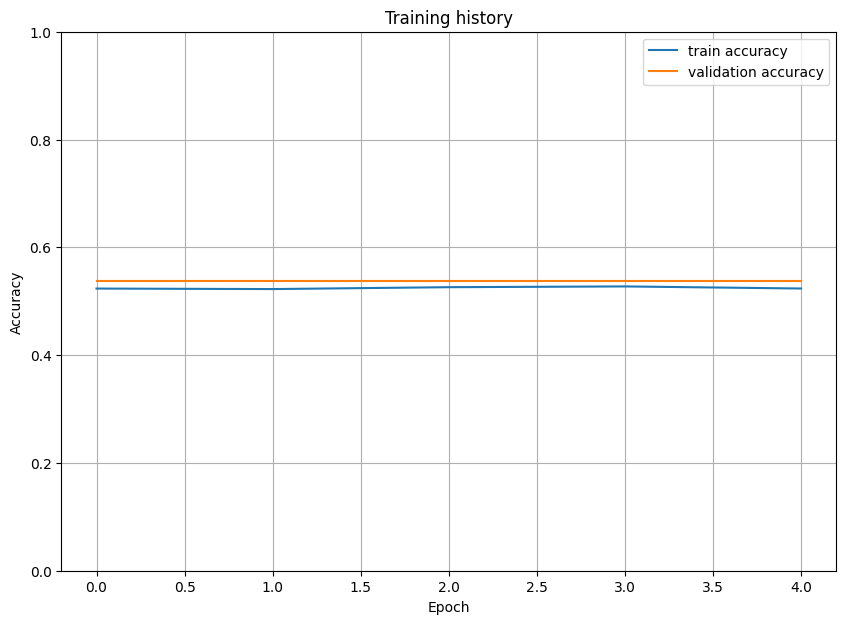

In [39]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

In [61]:
# Loading pretrained model (best model)
new_model = BERTClass()
new_model = torch.quantization.quantize_dynamic(
    new_model, {torch.nn.Linear}, dtype=torch.qint8)
new_model.to(device)
new_model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))


<All keys matched successfully>

In [60]:
new_model

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (key): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (value): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (dropout): Dropout(p=0.1, inplace=False)
            )
        

In [62]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, new_model, optimizer)


# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.5362422508345255